# Getting started with Modulus - Simulating projectile motion

- https://github.com/openhackathons-org/End-to-End-AI-for-Science/blob/688a7244b6ec0c6fa1bb939926e6a45979161248/workspace/python/jupyter_notebook/projectile/Getting_Started_Projectile.ipynb

This notebook will give you a headstart in solving your Partial Differential Equations (PDEs) using neural networks. 

Let's quickly recap the theory of PINNs before proceeding. We will embed the physics of the problem in the neural networks. In such a setting, we can use them to approximate the solution to a given differential equation and boundary condition without any training data from other solvers. More specifically, the neural network will be trained to minimize a loss function formed using the differential equation and the boundary conditions. If the network can minimize this loss, then it will, in effect solve the given differential equation. More information about the Physics Informed Neural Networks (PINNs) can be found in the <a href="https://www.sciencedirect.com/science/article/pii/S0021999118307125?casa_token=1CnSbVeDwJ0AAAAA:-8a6ZMjO7RgYjFBAxIoVU2sWAdsqFzLRTNHA1BkRryNPXx5Vjc8hCDCkS99gcZR0B1rpa33a30yG" rel="nofollow">paper</a> published by Raissi et al. 
You can refer to the <a href="https://docs.nvidia.com/deeplearning/modulus/index.html" rel="nofollow">Modulus User Documentation</a> for more examples on solving different types of PDEs using the Modulus library, Modulus APIs, Release notes, etc. 


#### Contents of the Notebook

- [Simulating the Projectile Motion ODE](#Simulating-the-Projectile-Motion-ODE)
    - [Case Setup](#Case-Setup)
    - [Step 1: Creating the geometry](#Step-1:-Creating-the-geometry)
    - [Step 2: Defining the differential equations for the problem and creating the nodes](#Step-2:-Defining-the-differential-equations-for-the-problem-and-creating-the-nodes)
    - [Step 3: Setting up the Domain,a ssigning the boundary and PDE constraints](#Step-3:-Setting-up-the-Domain,a-ssigning-the-boundary-and-PDE-constraints)
    - [Step 4: Adding Validation and Inferencers to the Domain](#Step-4:-Adding-Validation-and-Inferencers-to-the-Domain)
    - [Step 5: Using Hydra to configure Modulus](#Step-5:-Using-Hydra-to-configure-Modulus)
    - [Step 6: Putting everything together: Solver and training](#Step-6:-Putting-everything-together:-Solver-and-training)
    - [Visualizing the solution](#Visualizing-the-solution)
- [Introduction to Paraview](#Introduction-to-Paraview)
    - [Installing Paraview](#Installing-Paraview:)
    - [Getting Started with Paraview](#Getting-Started-with-ParaView)
        
#### Learning Outcomes
- How to use Modulus to simulate physics problems using PINNs
- How to write your own PDEs and formulate the different losses
- How to define a domain and specify constraints
- How to monitor the training of the PINNs using Tensorboard

## Simulating the Projectile Motion ODE

Our aim in this setup is to obtain the position of a point mass as a function of time $ ( x(t) , y(t) )$ which is given an initial velocity from the origin at the initial moment ( $t=0$ ), this 2-d space has a constant gravitational acceleration ( $g=-9.8m/s^2$ ) and air resistance can be neglected. The sample output path of the problem can be seen below. While we are familiar with the equations of motions, we can differentiate it to obtain the differential equations for this system.
<center><img src="https://raw.githubusercontent.com/openhackathons-org/End-to-End-AI-for-Science/688a7244b6ec0c6fa1bb939926e6a45979161248/workspace/python/jupyter_notebook/projectile/images/projectile.svg" alt="Drawing" style="width:600px" /></center>


The equations of motion for such a system are defined as follows: 
$$
S_x = V_{0x} t \\
S_y = V_{0y} t + \frac{1}{2} g t^2 
$$
The above equation when differentiated with respect to time gives us the following:  
$$
\frac{dS_x}{dt} = V_{0x} \\
\frac{dS_y}{dt} = V_{0y} + gt
$$
While you may setup the problem statement with these equations, in this setup we will be using further differentiate it to get the second-order derivatives with respect to time as following and using it in our setup: 
$$
\frac{\mathrm{d}^2 S_x}{\mathrm{d} t^2} = 0 \\
\frac{\mathrm{d}^2 S_y}{\mathrm{d} t^2} = g
$$
The above second order differential equations can now be used to setup our case, in this case while we are aware of the analytical solutions, a lot of the complex systems are defined using Partial differential equations and a finding an analytical solution might not be straight-forward when the complexity of equations increases.


### Case Setup

Now that we have our problem defined, let's look at the code required to solve it using Modulus. Modulus has a variety of helper functions/APIs that will help us to set up the problem with ease. It has APIs to model geometry in a parameterized fashion using the Constructive Solid Geometry (CSG) module, write up the required equations in a user-friendly symbolic format and comes with several advanced neural network architectures to choose from for more complicated problems. 
Now let's start the problem by importing the required libraries and packages

```python
import numpy as np
from sympy import Symbol, sin, cos, pi,  Eq
import torch
import modulus
from modulus.sym.hydra import instantiate_arch, ModulusConfig
from modulus.sym.solver import Solver
from modulus.sym.domain import Domain
from modulus.sym.geometry.primitives_1d import Line1D,Point1D
from modulus.sym.geometry.primitives_2d import Rectangle
from modulus.sym.domain.constraint import (
        PointwiseBoundaryConstraint,
        PointwiseInteriorConstraint,
)
from modulus.sym.domain.inferencer import PointwiseInferencer
from modulus.sym.domain.validator import PointwiseValidator
from modulus.sym.key import Key
from modulus.sym.node import Node
from projectile_eqn import ProjectileEquation
from modulus.sym.utils.io import (
    csv_to_dict,
    ValidatorPlotter,
    InferencerPlotter,
)

```

From v22.03 modulus supports APIs for solving data-driven problems where the data is available on grid/mesh as well as the PINN problems where point clouds are used for problem formulation. In this section, since we will be solving the projectile problem using the PINN approach, we will use the functions and classes from the `modulus.solver` module. The `Solver` class trains and evaluates the Modulus' neural network solver. The `Domain` class is used to add constraints, monitors, validators, etc. to the problem.

The `geometry` module contains predefined geometries respectively that one can use to define the problem. We will describe each of them in detail as we move forward in the code. For more detailed information on all the different modules, we recommend you to refer the [Modulus API Documentation](https://docs.nvidia.com/deeplearning/modulus/modulus-sym/api/api_index.html).

### Step 1: Creating the geometry

In this problem, we will create a 1-dimensional geometry using `Point1D` class from the geometry module. The module also contains several 2d and 3d shapes like rectangle, circle, triangle, cuboids, sphere, torus, cones, tetrahedrons, etc. We will define the one-dimensional (1D) Point mass object for our simulation.

```python
# params for domain
geo = Point1D(0)
```

### Step 2: Defining the differential equations for the problem and creating the nodes

The `PDE` class allows us to write the equations symbolically in Sympy. This allows you to quickly write your equations in the most natural way possible. The Sympy equations are converted to PyTorch expressions in the back-end and can also be printed to ensure correct implementation.

Modulus also comes with several common PDEs predefined for the user to choose from. Some of the PDEs that are already available in the PDEs module are: Navier Stokes, Linear Elasticity, Advection Diffusion, Wave Equations, etc.

Let's create the PDE to define the equation.
$$
\frac{\mathrm{d}^2 S_x}{\mathrm{d} t^2} = 0 \\
\frac{\mathrm{d}^2 S_y}{\mathrm{d} t^2} = g
$$

Let's start defining the equation by inhereting from the `PDE` class. We will create the initialization method for this class that defines the equation(s) of interest.

```python
class ProjectileEquation(PDE):
    name = "ProjectileEquation"

    def __init__(self):

        #time
        t = Symbol("t")

        #make input variables
        input_variables = {"t": t}

        #make y function
        x = Function("x")(*input_variables)
        y = Function("y")(*input_variables)
        

        #set equation
        self.equations = {}
        self.equations["ode_x"] = x.diff(t,2)
        self.equations["ode_y"] = y.diff(t,2)
```

First, we defined the input variable $t$ with Sympy symbols. Then we defined the functions for $x$, $y$ that are dependent on the input variable $t$. Using these, we can write out our equations. We store this equation in the class by adding it to the dictionary of `equations`.

Note that we moved all the terms of the PDE either to LHS or RHS. This way, while using the equations in the constraints, we can assign a custom source function to the <code>’ode_y’</code> or <code>’ode_x’</code> key instead of 0 to add more source terms to our PDE.
Great! We just wrote our own PDE in Modulus! Once you have understood the process to code a simple PDE, you can easily extend the procedure for different PDEs. You can also bundle multiple PDEs together in the same file by adding new keys to the equations dictionary. 
<em>(More examples of coding your own PDE can be found in the <a href="https://docs.nvidia.com/deeplearning/modulus/modulus-sym/user_guide/foundational/1d_wave_equation.html" rel="nofollow">Modulus User Documentation</a>)</em>. 


#### Creating the Neural Network nodes

The default `FullyConnectedArch` (selected by setting `cfg.arch.fully_connected` in the `cfg` argument of the `instantiate_arch()` function) can be used to create the neural network for the problem. The default `FullyConnectedArch` represents a 6 layer MLP (multi-layer perceptron) architecture with each layer containing 512 nodes and uses swish as the activation function. All these parameters are user configurable, and can be configured using Hydra config files. Once all the PDEs and architectures are defined, we can create a list of nodes to pass to different constraints we want to satisfy for this problem (i.e. equations residuals, boundary conditions, etc.).

We will define all the code for the problem in the `run` function as shown below. 

```python  
@modulus.sym.main(config_path="conf", config_name="config")
def run(cfg: ModulusConfig) -> None:
    #Creating Nodes and Domain
    pe = ProjectileEquation()
    projectile_net = instantiate_arch(
        input_keys=[Key("t")],
        output_keys=[Key("x"),Key("y")],
        cfg=cfg.arch.fully_connected,
    )

    nodes = pe.make_nodes() + [projectile_net.make_node(name="projectile_network")]
```

### Step 3: Setting up the Domain, assigning the boundary and PDE constraints

As described earlier, we need to define a domain for training our neural network. The `Domain` and the configs are passed as inputs when using the `Solver` class. Apart from constraints, you can add various other utilities to the `Domain` such as monitors, validation data, points to do inference on, etc. 

```python
    # make domain to add constraints to the solver
    projectile_domain = Domain()
```

Now let’s look into adding constraints to this domain. This can be thought of as adding specific constraints to the neural network optimization. For this physics-driven problem, these constraints are the boundary conditions and equation residuals. The goal is to satisfy the boundary conditions exactly and ideally have the PDE residuals go to 0. These constraints can be specified within Modulus using classes like `PointwiseBoundaryConstrant` and `PointwiseInteriorConstraint`. An L2 loss (default and can be modified) is then constructed from these constraints, which is used by the optimizer to minimize on.

$$L = L_{BC} + L_{Residual}$$
<strong>Boundary constraints:</strong> For generating a boundary condition, we need to sample the points on the required boundary/surface of the geometry, specify the nodes we would like to unroll/evaluate on these points and then assign them the desired values. 
A boundary can be sampled using <code>PointwiseBoundaryConstraint</code> class. This will sample the entire boundary of the geometry we specify in the <code>geometry</code> argument. In this case, we defined the geometry as a 1d point mass.
The desired values for the boundary condition are listed as a dictionary in <code>outvar</code> argument. 
For this problem,  we have set up two boundary conditions.
<ul>
<li>Initial condition ( $t=0$ ): We set the origin to be our starting point ( <code>'x': 0.0</code> ,<code>'y':0.0</code> ) and give it an initial velocity (<code>'x__t':v_o*cos(theta)</code>, <code>'y__t':v_o*sin(theta)</code> ). </li>
<li>Rest of the time range ($t=(0,5) $): We will then set to solve the differential equations defined for the specific periods of time range ( <code>'ode_x':0.0</code> and <code>'ode_y':-9.81</code>) denoting that there is no acceleration other than gravitational acceleration. </li>
</ul>
These dictionaries are then used when unrolling the computational graph (specified using the <code>nodes</code> argument) for training.
The number of points to sample on each boundary is specified using the <code>batch_size</code> parameter. 

```python
    #Add Constraints to solver
    v_o = 40.0                   # Initial velocity
    theta = np.pi/3              # Initial anagle 
    time_range = {t :(0.0,5.0)}  # Time range to solve the PDE

    # Initial condition
    IC = PointwiseBoundaryConstraint(
            nodes = nodes,
            geometry = geo,
            outvar = {"x": 0.0,"y":0.0, "x__t":v_o*cos(theta), "y__t":v_o*sin(theta)},
            batch_size = cfg.batch_size.initial_x,
            parameterization = {t:0.0}
    )
    projectile_domain.add_constraint(IC,"IC")

    # Solving PDE for the time range. 
    interior = PointwiseBoundaryConstraint(
            nodes = nodes,
            geometry = geo,
            outvar = {"ode_x":0.0,"ode_y":-9.81},
            batch_size = cfg.batch_size.interior,
            parameterization = time_range,
    )   
    projectile_domain.add_constraint(interior,"interior")
```

### Step 4: Adding Validation and Inferencers to the Domain  

#### Adding Validator

For this problem, since we are aware of the solution, The analytical solution can then be given as:

$$
S_x = V_{0x} t \\
S_y = V_{0y} t + \frac{1}{2} g t^2 
$$


Now, let's create the validators. The validation data is added to the domain using the `PointwiseValidator` class. We use numpy to solve for the `x` and `y` based on the analytical expressions above. The dictionary of generated numpy arrays (`invar_numpy` and `outvar_numpy`) for input and output variables and the appropriate nodes are used in the definition of the constructor. 

```python
    # Setup validator
    delta_T = 0.01
    t_val = np.arange(0.,5.,delta_T)
    T_val = np.expand_dims(t_val.flatten(), axis = -1)
    X_val =  v_o*np.cos(theta)*T_val
    Y_val =  v_o*np.sin(theta)*T_val - 0.5*9.81*(T_val**2)
    
    invar_numpy = {"t": T_val}
    outvar_numpy = {"x":X_val, "y": Y_val}
    
    validator = PointwiseValidator(
            nodes=nodes,
            invar=invar_numpy,
            true_outvar=outvar_numpy,
            batch_size=128,
            plotter = ValidatorPlotter(),
    )
    projectile_domain.add_validator(validator)
```

#### Adding Inferencer 

Modulus also allows you to plot the results on arbitrary domains. You can then monitor these domains in Paraview or Tensorboard itself. More details on how to add Modulus information to Tensorboard can be found in TensorBoard in Modulus. The code below shows the use of PointwiseInferencer.

In the code below, we create Inferencer for $x$ and $y$ for a period of 8 seconds of time.

The points to sample can be selected in a similar way as we did for specifying the interior constraints.

```python
    # Setup Inferencer
    t_infe = np.arange(0,8,0.001)
    T_infe = np.expand_dims(t_infe.flatten(), axis = -1)
    invar_infe = {"t":T_infe}

    grid_inference = PointwiseInferencer(
        nodes=nodes,
        invar=invar_infe,
        output_names=["x","y"],
        batch_size=128,
        plotter=InferencerPlotter(),
    )
    projectile_domain.add_inferencer(grid_inference, "inferencer_data")
```

### Step 5: Using Hydra to configure Modulus

At the heart of using Modulus are Hydra config files. The one for this example can be found in the code shown below. Using hydra allows a highly customizable but user-friendly method for configuring the majority of Modulus’ features. More information can be found in <a href="https://docs.nvidia.com/deeplearning/modulus/modulus-sym/user_guide/features/configuration.html" rel="nofollow">Modulus Configuration</a>.

```yaml
defaults :
  - modulus_default
  - arch:
      - fully_connected
  - scheduler: tf_exponential_lr
  - optimizer: adam
  - loss: sum
  - _self_

save_filetypes : "vtk,npz"

scheduler:
  decay_rate: 0.95
  decay_steps: 100


training:
  rec_validation_freq: 1000
  rec_inference_freq: 1000
  rec_monitor_freq: 1000
  rec_constraint_freq: 2000
  max_steps : 5000

batch_size:
  initial_x: 100
  interior: 1000
  
graph: 
  func_arch: true
   
cuda_graphs: True
cuda_graph_warmup: 20
```

### Step 6: Putting everything together: Solver and training

We can create a solver by using the domain we just created along with the other configurations that define the optimizer choices, and settings (i.e. conf) using Modulus’ `Solver` class. The solver can then be executed using the `solve` method. 

```python
    # make solver
    slv = Solver(cfg, projectile_domain)

    # start solver
    slv.solve()


if __name__ == "__main__":
    run()
```

Awesome! We have just completed the file set-up for the problem using the Modulus library. We are now ready to solve the PDEs using Neural Networks!

Before we can start training, we can make use of Tensorboard for visualizing the loss values and convergence of several other monitors we just created. This can be done inside the Jupyter framework by selecting the directory in which the checkpoint will be stored by clicking on the small checkbox next to it. 

We can launch tensorboard using the following command: 

```
tensorboard --logdir /workspace/python/jupyter_notebook/ --port 8889
```

Open a new tab in your browser and head to [http://127.0.0.1:8889](http://127.0.0.1:8889). You should see a screen similar to the below one. 

<center><img src="https://raw.githubusercontent.com/openhackathons-org/End-to-End-AI-for-Science/688a7244b6ec0c6fa1bb939926e6a45979161248/workspace/python/jupyter_notebook/projectile/images/tensorboard_browser.png" alt="Drawing" style="width:900px" /></center>

Also, as Modulus uses Hydra for config management, this causes issues when the code is directly executed through the jupyter notebook. Hence, we will save the code in form of a python script and run that script inside the jupyter cell. This example is already saved for you, and the code block below executes that script <code>projectile.py</code>. You are encouraged to open the script and review the code once before executing. Also, feel free to edit the parameters in the <code>config.yaml</code> file of the model and see its effect on the results.

In [ ]:
import os
os.environ["RANK"]="0"
os.environ["WORLD_SIZE"]="1"
os.environ["MASTER_ADDR"]="localhost"

In [ ]:
!python ./src/projectile.py

/usr/local/lib/python3.10/dist-packages/hydra/_internal/hydra.py:119: UserWarning: Future Hydra versions will no longer change working directory at job runtime by default.
See https://hydra.cc/docs/1.2/upgrades/1.1_to_1.2/changes_to_job_working_dir/ for more information.
  ret = run_job(
[W1229 11:13:05.131432149 init.cpp:779] Warning: nvfuser is no longer supported in torch script, use _jit_set_nvfuser_single_node_mode is deprecated and a no-op (function operator())
[W1229 11:13:05.131475420 init.cpp:767] Warning: nvfuser is no longer supported in torch script, use _jit_set_nvfuser_enabled is deprecated and a no-op (function operator())
[11:13:05] - JIT using the NVFuser TorchScript backend
[11:13:05] - Disabling JIT because functorch does not work with it.
[11:13:05] - JitManager: {'_enabled': False, '_arch_mode': <JitArchMode.ONLY_ACTIVATION: 1>, '_use_nvfuser': True, '_autograd_nodes': False}
[11:13:05] - GraphManager: {'_func_arch': True, '_debug': False, '_func_arch_allow_partial

### Visualizing the solution

Modulus saves the data in several formats (including .vtp, .vtk and .npz). The .npz arrays can be plotted to visualize the output of the simulation. The .npz files that are created are found in the `outputs/` directory. 

Now, let's plot the distance for the analytical and the neural network solution. A sample script to plot the results is shown below.

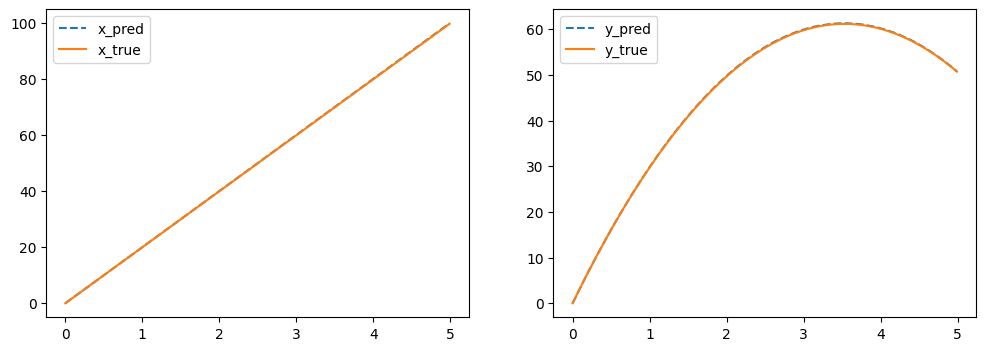

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 4))

network_dir = "./outputs/projectile/validators/"
data_1 = np.load(network_dir + "validator.npz", allow_pickle=True)
data_1 = np.atleast_1d(data_1.f.arr_0)[0]

plt.subplot(1, 2, 1)
plt.plot(data_1["t"][:, 0], data_1["pred_x"][:, 0], "--", label="x_pred")
plt.plot(data_1["t"][:, 0], data_1["true_x"][:, 0], label="x_true")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(data_1["t"][:, 0], data_1["pred_y"][:, 0], "--", label="y_pred")
plt.plot(data_1["t"][:, 0], data_1["true_y"][:, 0], label="y_true")
plt.legend()


plt.savefig("prediction")

We have now trained and visualised our first partial differential equation using Modulus. Let us now move ahead to solving complex equations using Modulus.

## Introduction to Paraview 

ParaView is an open-source, multi-platform application designed to visualize data sets of varying sizes from small to very large. The goals of the ParaView project include developing an open-source, multi-platform visualization application that supports distributed computational models to process large data sets. It has an open, flexible, and intuitive user interface. Furthermore, ParaView is built on an extensible architecture based on open standards. ParaView runs on distributed and shared memory parallel as well as single processor systems and has been successfully tested on Windows, Linux, Mac OS X, IBM Blue Gene, Cray XT3 and various Unix workstations and clusters. Under the hood, ParaView uses the Visualization Toolkit as the data processing and rendering engine and has a user interface written using the Qt cross-platform application framework. 

### Installing Paraview: 

For Installing Paraview, following the guidelines 

1. Navigate to the Paraview download webpage: [https://www.paraview.org/download/](https://www.paraview.org/download/)
2. Select the latest version 
3. Choose your operating system: Select the appropriate version for your OS (Windows, macOS, or Linux).Download the installer:
    - For Windows, download the `.msi` installer file.
    - For macOS, download the `.dmg` file.
    - For Linux, download the `.tar.gz` file.

4. Install ParaView:
    - On Windows:
        - a. Double-click the downloaded `.msi` file.
        - b. Follow the installation wizard prompts.
        - c. Choose the installation directory (default is usually fine).
        - d. Click "Finish" when the installation is complete.
    - On macOS:
        - a. Open the downloaded `.dmg` file.
        - b. Drag the ParaView application to your Applications folder.
    - On Linux:
        - a. Extract the downloaded package.
        - b. Navigate to the `bin` folder and launch `pararview`
        - c. Install any missing dependencies if prompted.
        - d. Add the ParaView executable to your `$PATH`. Example: In bash, you can execute: `export PATH="/path/to/Paraview/#.#.#/bin:$PATH"`
5. Launch ParaView:
    - On Windows: Search for "ParaView" in the Start menu and click to open.
    - On macOS: Open ParaView from the Applications folder.
    - On Linux: Launch the executable from the `bin` folder or if already added to `PATH`, then type paraview in the terminal or find it in your applications menu.
6. Verify the installation: Once launched, you should see the ParaView interface with its main window and toolbars.


### Getting Started with ParaView

Let us take the example of projectile motion and download the `.vtp` files from `jupyter_notebook/projectile/outputs`. 

- Initial Condition: `outputs/projectile/constraints/IC.vtp`
- Interior Constraits: `outputs/projectile/constraints/interior.vtp`
- Inference Data: `outputs/projectile/inferencers/inferencer_data.vtp`
- Validation Data: `outputs/projectile/validators/validator.vtp`

ParaView is a powerful software that comes with lots of inbuilt tools to use. To get started, here's a brief introduction to using ParaView:

`paraview` is the graphical front-end to the ParaView application. The UI is designed to allow you to easily create pipelines for data processing with arbitrary complexity. The UI provides panels for you to inspect and modify the pipelines, to change parameters that in turn affect the processing pipelines, to perform various data selection and inspection actions to introspect the data, and to generate renderings. 

Let’s start by looking at the various components of the UI. If you run paraview for the first time, you will see something similar to the above figure. The UI consists of of menus, dockable panels, toolbars, and the viewport – the central portion of the application window.

Menus provide the standard set of options typical with a desktop application including options for opening/saving files (File menu), for undo/redo (Edit menu), for the toggle panel, and for toolbar visibilities (View menu). Additionally, the menus provide ways to create sources that generate test datasets of various types (Sources menu), as well new filters for processing data (Filters menu). The Tools menu provides access to some of the advanced features in paraview such as managing plugins and favorites.

Panels provide you with the ability to peek into the application’s state. For example, you can inspect the visualization pipeline that has been set up ( Pipeline Browser ), as well as the memory that is being used ( Memory Inspector ) and the parameters or properties for a processing module ( Properties panel). Several of the panels also allow you to change the values that are displayed, e.g., the Properties panel not only shows the processing module parameters, but it also allows you to change them. Several of the panels are context sensitive. For example, the Properties panel changes to show the parameters from the selected module as you change the active module in the Pipeline Browser .

Toolbars are designed to provide quick access to common functionality. Several of the actions in the toolbar are accessible from other locations, including menus or panels. Similar to panels, some of the toolbar buttons are context sensitive and will become enabled or disabled based on the selected module or view.

The viewport or the central portion of the paraview window is the area where ParaView renders results generated from the data. The containers in which data can be rendered or shown are called views. You can create several different types of views, all of which are laid out in this viewport area. By default, a 3D view is created, which is one of the most commonly used views in ParaView.

Let us now get started with a Basic Workflow:
- Let us download and open Interior Constraits(`outputs/projectile/constraints/interior.vtp`) as this would have captured the points generated during the model training. 
- Open the `interior.vtp` in ParaView as shown below.  
- Click on the Eye Icon to make the source visible. 
- Enable Data Grid for better visualisation 
- Adding a Color Map to distingush the Time axis. 

<center><img src="https://raw.githubusercontent.com/openhackathons-org/End-to-End-AI-for-Science/688a7244b6ec0c6fa1bb939926e6a45979161248/workspace/python/jupyter_notebook/projectile/images/paraview_open.png" alt="Drawing" style="center"/></center>


Open you open the file, you can use the below annotated images as references to add Axis Grids and Color Maps for better visualisation.

<center><img src="https://raw.githubusercontent.com/openhackathons-org/End-to-End-AI-for-Science/688a7244b6ec0c6fa1bb939926e6a45979161248/workspace/python/jupyter_notebook/projectile/images/paraview_display.png" alt="Drawing" style="center"/></center>

The scope of ParaView's capabilities is quite extensive and goes well beyond what can be covered in this notebook. For a comprehensive understanding of ParaView's features and functionality, We would strongly encourage you to explore the official ParaView [documentation](https://docs.paraview.org/en/latest/) and [User Guide](https://docs.paraview.org/en/latest/UsersGuide/index.html). 